In [1]:
import os
import random
import numpy as np
import pandas as pd
import sys

# 1. 轉檔 (xml to txt)

In [2]:
current_dir = os.getcwd()
pkg_rootdir = os.path.dirname(os.path.dirname(current_dir))
if pkg_rootdir not in sys.path:
    sys.path.append(pkg_rootdir)
from ai_rebin.utility.ProgressBar import progressBar
from utility.XmlProcessing import xmlProcessing

In [3]:
labelpath = 'FM_model-checked/'           #設定路徑
imgpath = 'FM_model-checked/'
yolopath = 'FM_model-checked_yolov7/'
train_test_split = 0.1
os.makedirs(yolopath + 'images/train', exist_ok=True)
os.makedirs(yolopath + 'images/val', exist_ok=True)
os.makedirs(yolopath + 'labels/train', exist_ok=True)
os.makedirs(yolopath + 'labels/val', exist_ok=True)
xml_list = sorted([file for file in os.listdir(labelpath) if file.split('.')[-1] == 'xml'])
random.shuffle(xml_list)
total_progress = len(xml_list)
progress = 0
progress_Bar=progressBar()
progress_Bar.start('getYoloFormat')
xml_handler=xmlProcessing().setup_classes_dict(classes_dict={'OK_Area':0,'NG_Area':1,'NG_Other':2})
for f in xml_list:   #透過getYoloFormat將圖像和參數檔全部寫到YOLO下
    progress += 1
    try:
        if progress/len(xml_list) > train_test_split:
            xml_handler.getYoloFormat(f, labelpath, imgpath, yolopath, 'train')
        else:
            xml_handler.getYoloFormat(f, labelpath, imgpath, yolopath, 'val')
    except Exception as e:
        print(e)
    
    progress_Bar.update(progress,total_progress)

getYoloFormat:100.0% [********************] 1289/1289 15.2s FPS=84.9
the getYoloFormat ends at 2022-11-09 07:03:26 .
+-------+----------+---------+------+
| Total | Progress | Time(s) | FPS  |
+-------+----------+---------+------+
|  1289 |   100%   |   15.2  | 84.9 |
+-------+----------+---------+------+


# 2. model train

> 參考 : https://chtseng.wordpress.com/2022/07/18/yolov7%E5%98%97%E9%AE%AE/

```
usage: launch.py [-h] [--nnodes NNODES] [--nproc_per_node NPROC_PER_NODE]
                 [--rdzv_backend RDZV_BACKEND] [--rdzv_endpoint RDZV_ENDPOINT]
                 [--rdzv_id RDZV_ID] [--rdzv_conf RDZV_CONF] [--standalone]
                 [--max_restarts MAX_RESTARTS]
                 [--monitor_interval MONITOR_INTERVAL]
                 [--start_method {spawn,fork,forkserver}] [--role ROLE] [-m]
                 [--no_python] [--run_path] [--log_dir LOG_DIR] [-r REDIRECTS]
                 [-t TEE] [--node_rank NODE_RANK] [--master_addr MASTER_ADDR]
                 [--master_port MASTER_PORT] [--use_env]
                 training_script ...

```

```
usage: train.py [-h] [--weights WEIGHTS] [--cfg CFG] [--data DATA] [--hyp HYP]
                [--epochs EPOCHS] [--batch-size BATCH_SIZE]
                [--img-size IMG_SIZE [IMG_SIZE ...]] [--rect]
                [--resume [RESUME]] [--nosave] [--notest] [--noautoanchor]
                [--evolve] [--bucket BUCKET] [--cache-images]
                [--image-weights] [--device DEVICE] [--multi-scale]
                [--single-cls] [--adam] [--sync-bn] [--local_rank LOCAL_RANK]
                [--workers WORKERS] [--project PROJECT] [--entity ENTITY]
                [--name NAME] [--exist-ok] [--quad] [--linear-lr]
                [--label-smoothing LABEL_SMOOTHING] [--upload_dataset]
                [--bbox_interval BBOX_INTERVAL] [--save_period SAVE_PERIOD]
                [--artifact_alias ARTIFACT_ALIAS]
                [--freeze FREEZE [FREEZE ...]] [--v5-metric]
```

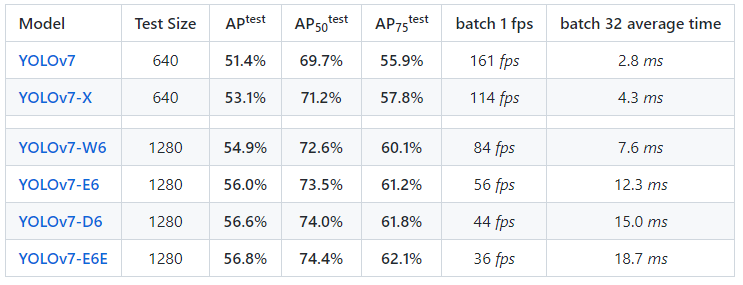

In [4]:
os.listdir('data/')

['hyp.scratch.p6.yaml',
 'FM_model.yaml',
 'hyp.scratch.custom.yaml',
 'hyp.scratch.p5.yaml',
 'coco.yaml',
 'hyp.scratch.tiny.yaml']

In [5]:
os.listdir('cfg/training/')

['yolov7.yaml',
 'yolov7x.yaml',
 'yolov7-FM_model.yaml',
 'yolov7-tiny.yaml',
 'yolov7-e6e.yaml',
 'yolov7-w6.yaml',
 'yolov7-e6.yaml',
 'yolov7x-FM_model.yaml',
 'yolov7-d6.yaml']

In [ ]:
! python -m torch.distributed.launch \
--nproc_per_node 4 \
--master_port 9527 \
train.py \
--workers 8 \
--device 0,1,2,3 \
--sync-bn \
--batch-size 64 \
--data data/FM_model.yaml \
--img 640 640 \
--cfg cfg/training/yolov7x.yaml \
--weights runs/train/yolov7x_FM_model_3class/weights/best.pt \
--name yolov7x_FM_model_3class_retrain \
--hyp data/hyp.scratch.p5.yaml

/opt/conda/lib/python3.7/site-packages/torch/distributed/launch.py:186: FutureWarning: The module torch.distributed.launch is deprecated
and will be removed in future. Use torchrun.
Note that --use_env is set by default in torchrun.
If your script expects `--local_rank` argument to be set, please
change it to read from `os.environ['LOCAL_RANK']` instead. See 
https://pytorch.org/docs/stable/distributed.html#launch-utility for 
further instructions

  FutureWarning,
*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
*****************************************
YOLOR 🚀 2022-10-7 torch 1.10.0 CUDA:0 (GeForce RTX 3090, 24268.3125MB)
                               CUDA:1 (GeForce RTX 3090, 24268.3125MB)
                               CUDA:2 (GeForce RTX 3090, 24268.3125MB)
                       

# 3. model test
```
usage: detect.py [-h] [--weights WEIGHTS [WEIGHTS ...]] [--source SOURCE]
                 [--img-size IMG_SIZE] [--conf-thres CONF_THRES]
                 [--iou-thres IOU_THRES] [--device DEVICE] [--view-img]
                 [--save-txt] [--save-conf] [--nosave]
                 [--classes CLASSES [CLASSES ...]] [--agnostic-nms]
                 [--augment] [--update] [--project PROJECT] [--name NAME]
                 [--exist-ok] [--no-trace]
```

In [10]:
!python detect.py \
--device 0,1 \
--weights runs/train/yolov7x_FM_model_3class_retrain/weights/best.pt \
--save-txt \
--conf 0.25 \
--iou 0.5 \
--source test/FM_NG/

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='0,1', exist_ok=False, img_size=640, iou_thres=0.5, name='exp', no_trace=False, nosave=False, project='runs/detect', save_conf=False, save_txt=True, source='test/FM_NG/', update=False, view_img=False, weights=['runs/train/yolov7x_FM_model_3class_retrain/weights/best.pt'])
YOLOR 🚀 2022-10-7 torch 1.10.0 CUDA:0 (GeForce RTX 3090, 24268.3125MB)
                               CUDA:1 (GeForce RTX 3090, 24268.3125MB)

Fusing layers... 
IDetect.fuse
/opt/conda/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272178570/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 362 layers, 70795920 parameters, 0 gradients, 188.2 GFLOPS
 Convert model to Traced-model... 
 tra